In [65]:
import warnings
import math
import db_func
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook, show
import matplotlib.pyplot as plt
from datetime import date, datetime
from tqdm.notebook import tqdm
import re
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')


In [134]:
match_df = pd.read_csv('all_matches.csv')

In [5]:
match_df['season'].describe()

count    19158.000000
mean      2014.950151
std          4.315090
min       2008.000000
25%       2011.000000
50%       2015.000000
75%       2019.000000
max       2022.000000
Name: season, dtype: float64

### Three Point Attempts Made Per 10 Minutes by Season

In [111]:
def plot_historical_rate(stat='', ylabel=''):
	grouped = match_df.groupby(['season'])
	dataframes = [group for _, group in grouped]
	y = []
	medians = []
	for i in range(len(dataframes)):
		y.append(dataframes[i].apply(lambda x: \
			((x['home_'+ stat] + x['away_'+stat]))/(x['sp']/(60*10)), axis=1))
		#y[i] = y[i].apply(lambda x: (x-y[i].mean())/ y[i].std())
		medians.append(y[i].mean())

	x = match_df['season'].unique()

	fig, ax1 = plt.subplots(figsize=(15, 7))
	plt.boxplot(y)
	ax1.set_xticklabels(x)

	ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
				alpha=0.5)

	ax1.set_axisbelow(True)
	ax1.set_title(ylabel)
	ax1.set_xlabel('Season')
	ax1.set_ylabel(ylabel)
	top = max([df.max() for df in y]) + 1
	bottom = 0
	ax1.set_ylim(bottom, top)
	ax1.set_xlim(0.5, len(medians) + 0.5)
	pos = np.arange(len(medians)) + 1
	for i in range(len(medians)):
		ax1.text(pos[i], top - (top *0.05), round(medians[i],2),
				horizontalalignment='center', size='small')
	plt.show()


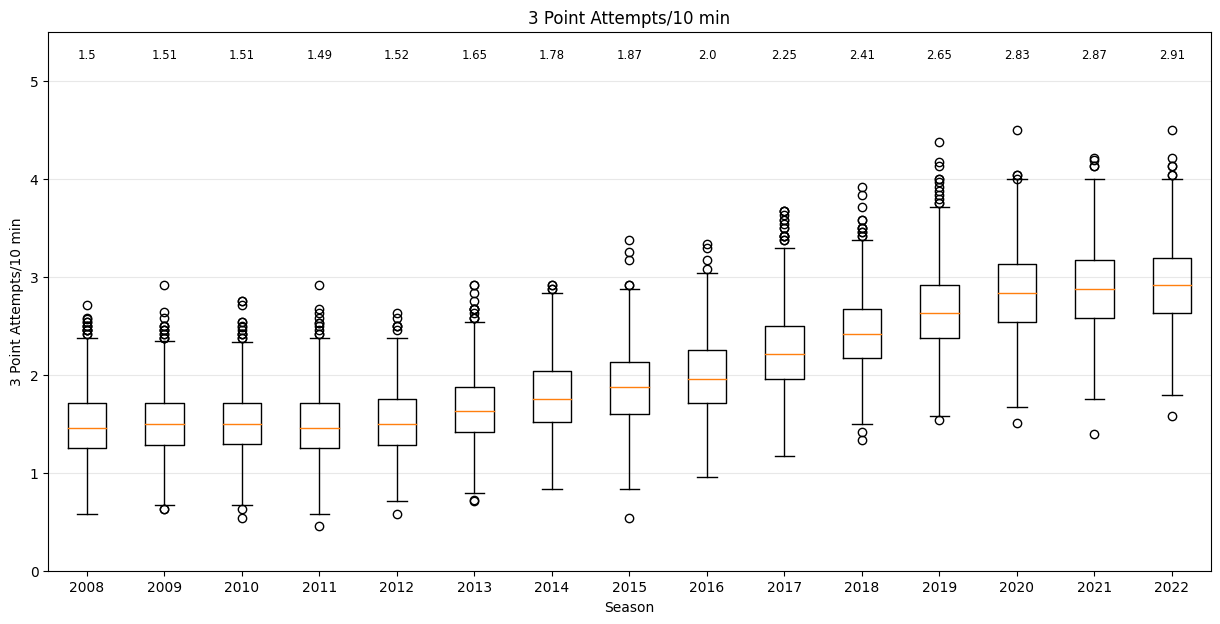

In [112]:
plot_historical_rate('3pa', 
	'3 Point Attempts/10 min')

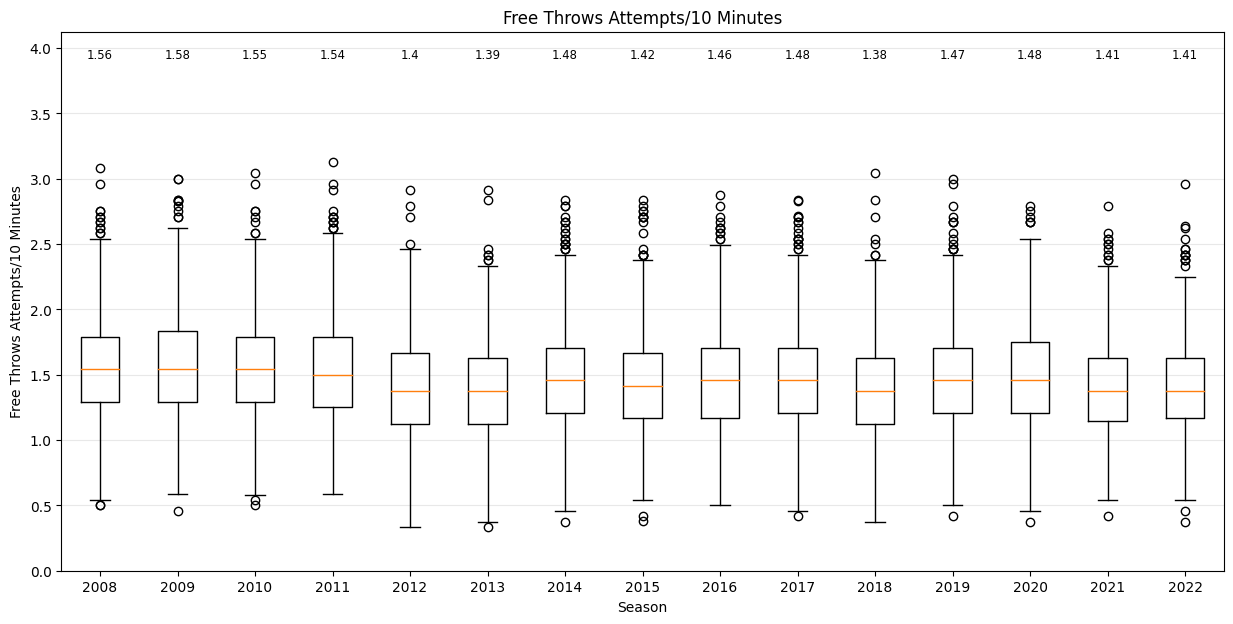

In [113]:
plot_historical_rate('ft', 'Free Throws Attempts/10 Minutes')

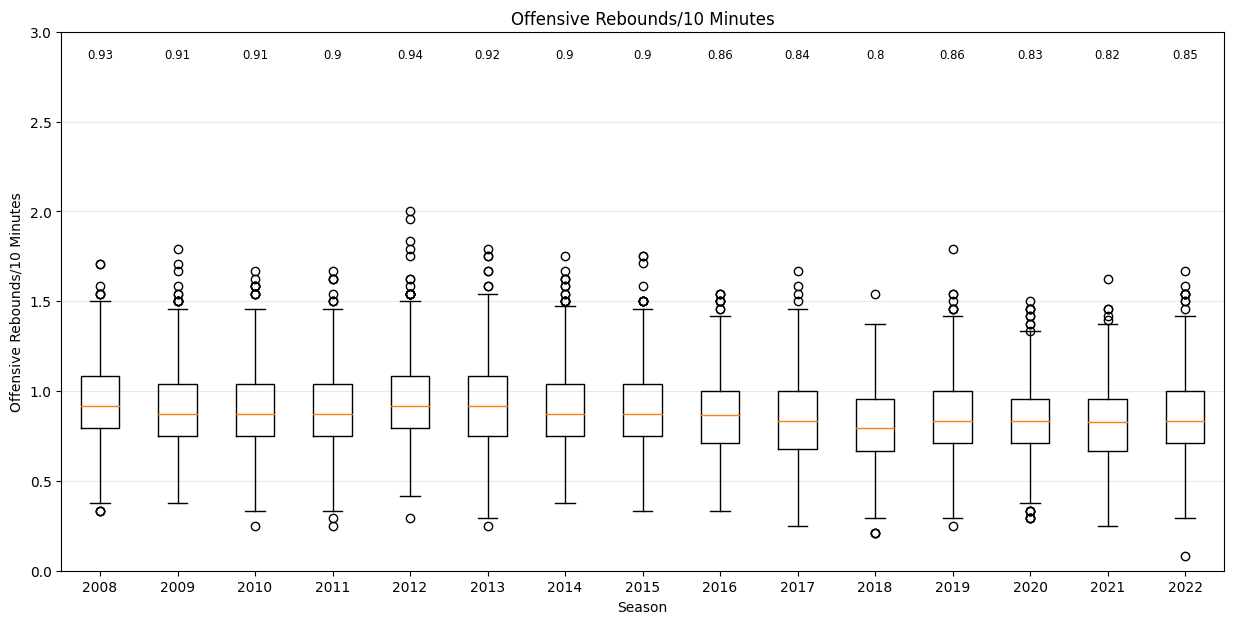

In [114]:
plot_historical_rate('orb', 'Offensive Rebounds/10 Minutes')

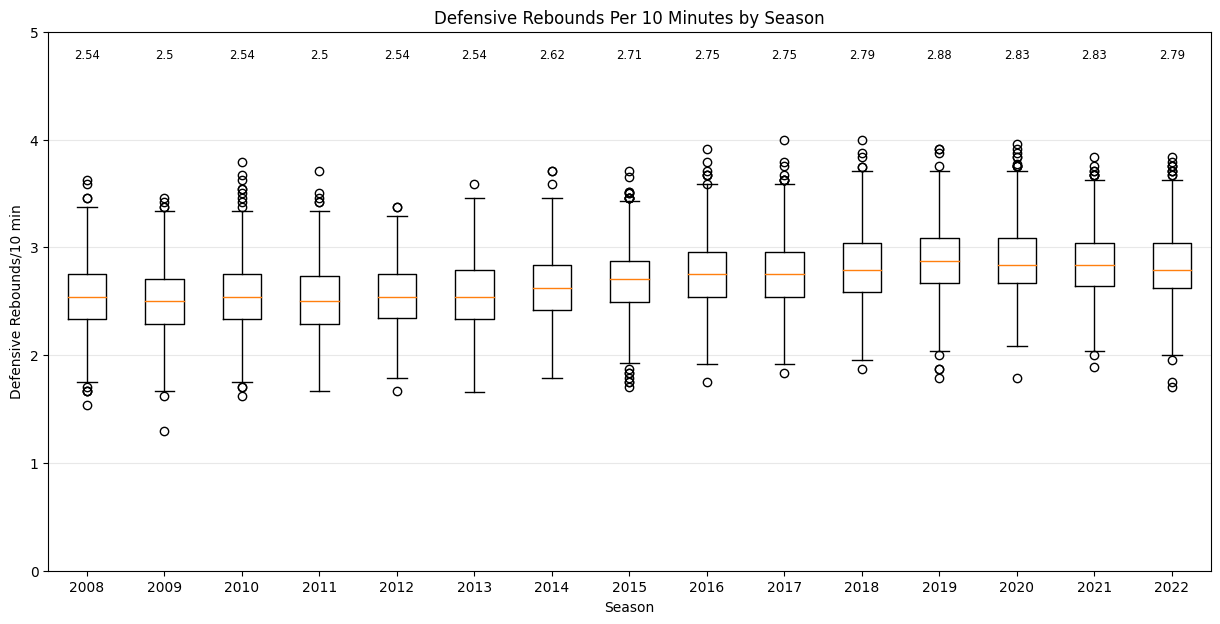

In [88]:
plot_historical_rate('drb', 'Defensive Rebounds/10 Minutes')

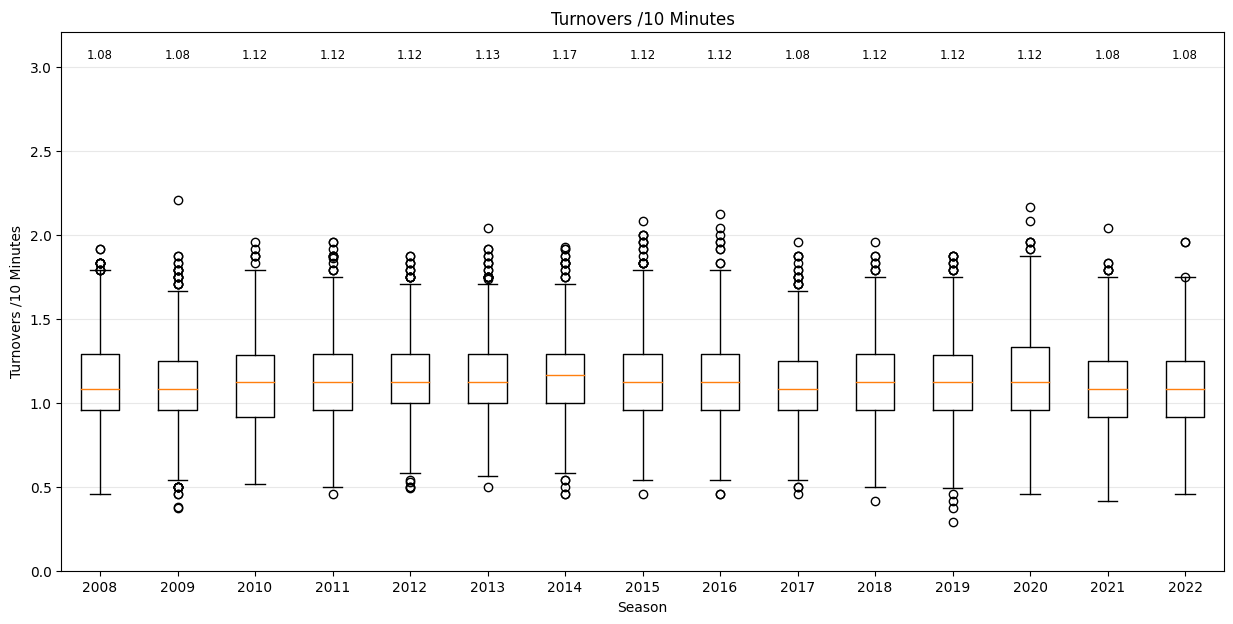

In [110]:
plot_historical_rate('tov','Turnovers /10 Minutes')

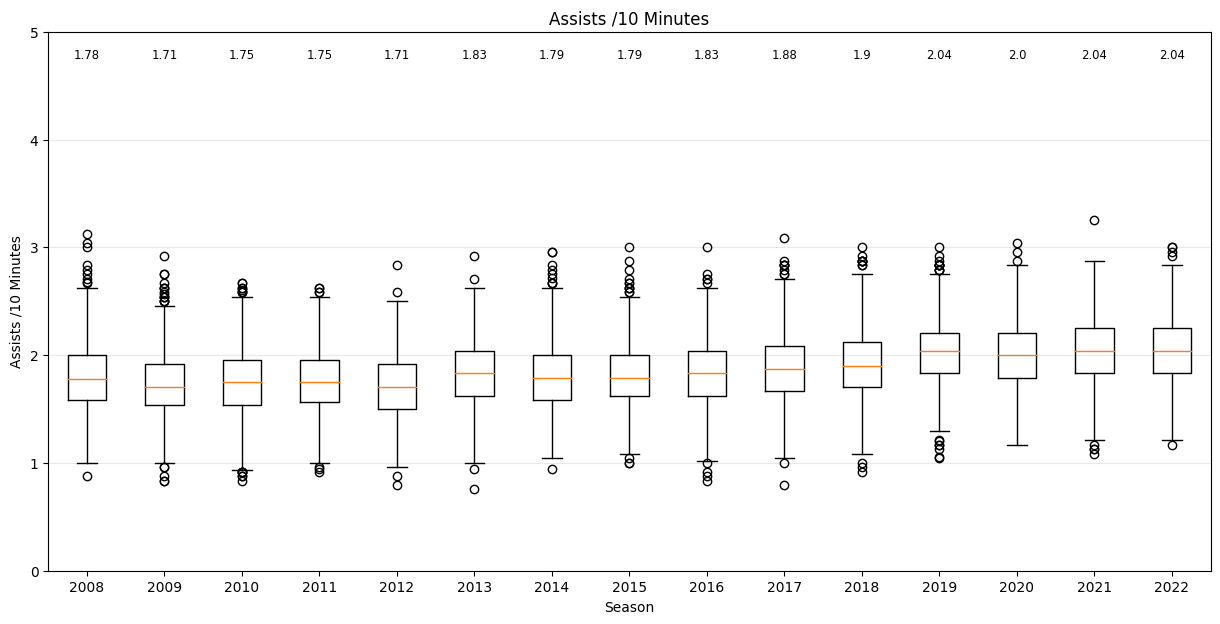

In [91]:
plot_historical_rate('ast','Assists /10 Minutes')


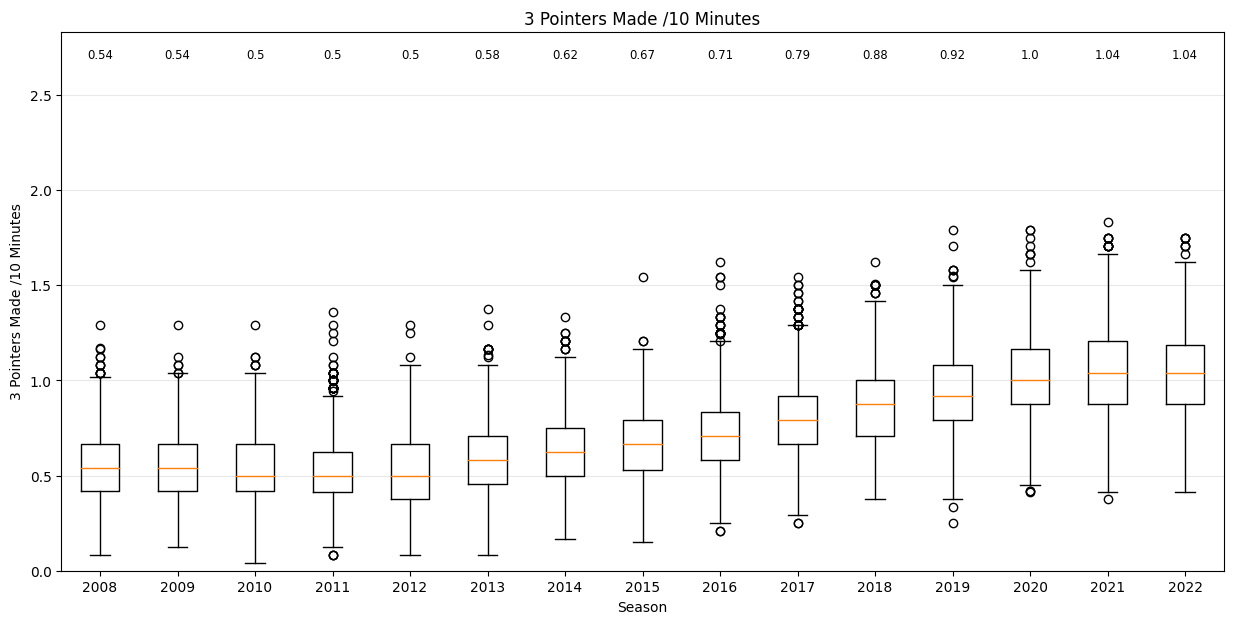

In [108]:
plot_historical_rate('3p','3 Pointers Made /10 Minutes')


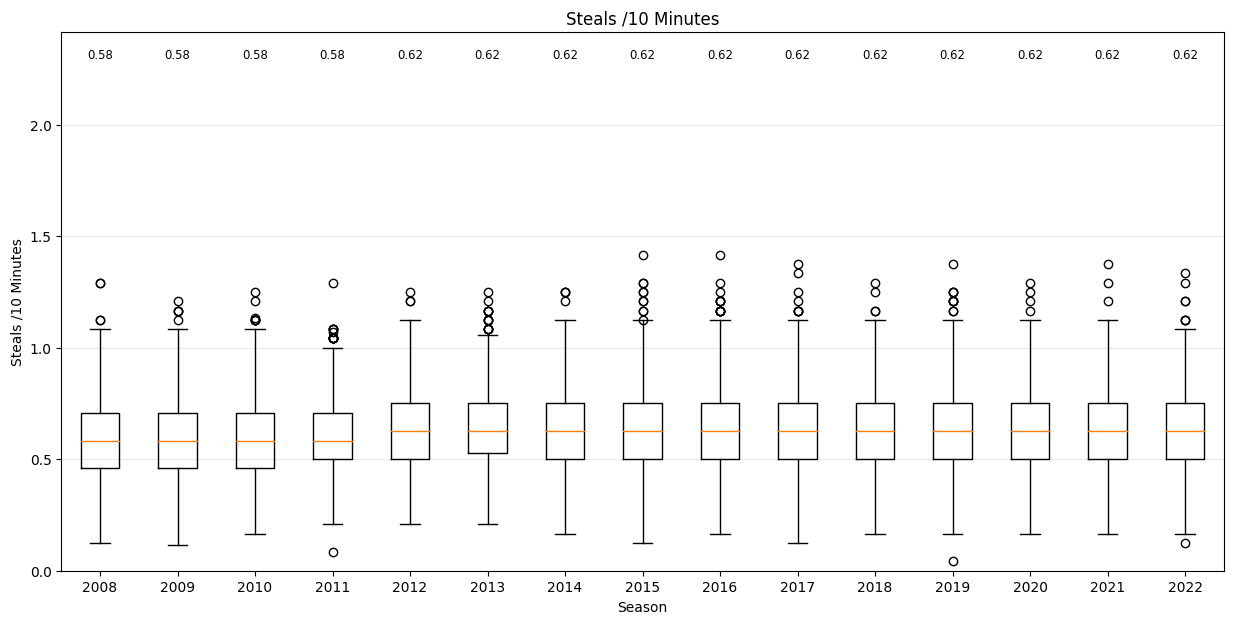

In [107]:
plot_historical_rate('stl','Steals /10 Minutes')


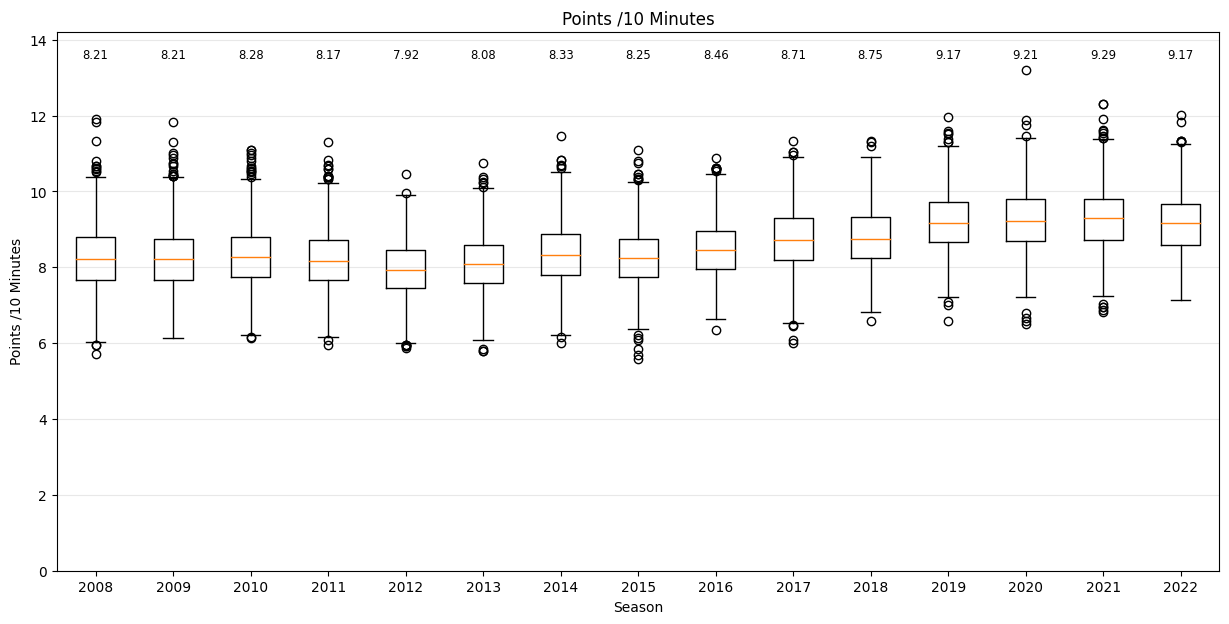

In [109]:
plot_historical_rate('pts','Points /10 Minutes')


### PCA

In [208]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
match_df = pd.read_csv('all_matches.csv')
match_df.dropna(inplace=True)
non_relevant_cols = ['movl', 'season', 'match_id', 'away_id', 'home_id', 
	'home_spread','away_spread', 'home_ps_odds', 'away_ps_odds', 'over', 'under', 
	'date', 'playoff_game', 'favorite', 'favorite_won', 'sp', 'spread']
X = match_df[match_df.columns.difference(non_relevant_cols)]
#X = match_df[['home_3pa', 'away_3pa', 'away_ast', 'home_ast']]
y = match_df.movl
# Z-score the features

X_scaled = scaler.fit_transform(X)

# The PCA model
pca = PCA(n_components=2) 
#X_new = pca.fit(X_scaled) # project the original data into the PCA space

In [199]:
components = pca.fit_transform(X_scaled)
components = pd.DataFrame(components).transpose()
print(components)

      0         1          2         3         4         5         6      \
0 -2.687169 -4.335272 -12.274647 -7.778303 -9.390033 -7.749524 -9.214961   
1 -4.755714  0.961391   1.911864  6.402959 -0.215357  1.665462  4.142166   

      7         8         9      ...     18538      18539     18540     18541  \
0 -7.733076 -7.230487 -3.569749  ... -4.059906  11.830857 -6.183584 -6.637474   
1  5.528888  1.554317  0.467318  ... -2.173649  -2.934937 -4.173886 -6.259815   

      18542     18543     18544     18545     18546     18547  
0  6.079335  9.989959  8.307616  5.360798  0.141696 -3.272684  
1 -1.115084 -1.114636 -1.599551 -4.053658 -8.386284 -8.432306  

[2 rows x 18548 columns]


In [195]:
var_ratio = pca.explained_variance_ratio_
var_ratio= pd.DataFrame(var_ratio).transpose()
var_ratio.columns = ['Comp1', 'Comp2']
var_ratio.index = ['Proportion of Variance']
print(var_ratio)

                           Comp1    Comp2
Proportion of Variance  0.109797  0.04423


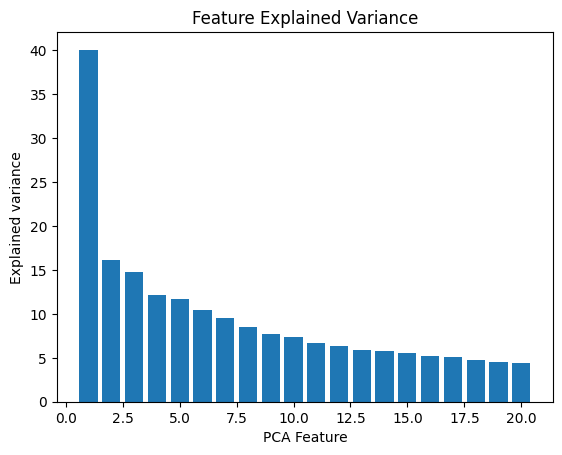

In [190]:
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

In [214]:
# Reduce from 4 to 2 features with PCA
pca = PCA(n_components=2)
 
# Fit and transform data
pca_features = pca.fit_transform(X_scaled)

# Create dataframe
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])
y = y.reset_index(drop=True)
pca_df['movl'] = y
pca_df.head()

,PC1,PC2,movl
0,-2.687169,-4.756138,3
1,-4.335278,0.959000,-2
2,-12.274645,1.908199,15
3,-7.778303,6.397592,22
4,-9.390031,-0.214769,-3


In [ ]:
def biplot(score, coeff , y):
    '''
    Author: Serafeim Loukas, serafeim.loukas@epfl.ch
    Inputs:
       score: the projected data
       coeff: the eigenvectors (PCs)
       y: the class labels
   '''
    xs = score[:,0] # projection on PC1
    ys = score[:,1] # projection on PC2
    n = coeff.shape[0] # number of variables
    plt.figure(figsize=(10,8), dpi=100)
    classes = np.unique(y)
    colors = ['g','r','y']
    markers=['o','^','x']
    for s,l in enumerate(classes):
        plt.scatter(xs[y==l],ys[y==l], c = colors[s], marker=markers[s]) # color based on group
    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1.5, overhang=0.2)
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center',fontsize=10)

    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
    limx= int(xs.max()) + 1
    limy= int(ys.max()) + 1
    plt.xlim([-limx,limx])
    plt.ylim([-limy,limy])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)